In [ ]:
import pickle
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import tensorflow as tf
!pip install segmentation-models
from random import randint
import tensorflow
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 7.6 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#insert the absolute path to your data and models folder here
DATA_PATH= "/content/drive/MyDrive/FANIYAN PROJECT/CODE/Saved models and Pickles/"

In [ ]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

# **Functions to calculate metrics**

In [ ]:
#number to round up decimal points by
DECIMAL_POINTS= 4

In [ ]:
#IOU FUNCTION
"""
from keras.metrics import MeanIoU
IOU_keras= MeanIoU(num_classes=3) 
IOU_keras.update_state(test_masks, test_pred)
print(IOU_keras.result().numpy())

values= np.array(IOU_keras.get_weights()).reshape(65536)
print(values)

class1_IoU = values[0]/(values[0] + values[0] + values[0] + values[0] + values[1]+ values[2]+ values[3])
class2_IoU = values[1]/(values[1] + values[1] + values[1] + values[1] + values[0]+ values[2]+ values[3])
class3_IoU = values[2]/(values[2] + values[2] + values[2] + values[2] + values[0]+ values[1]+ values[3])
class4_IoU = values[3]/(values[3] + values[3] + values[3] + values[3] + values[0]+ values[1]+ values[2])
print(class1_IoU, class2_IoU, class3_IoU, class4_IoU)

"""

def calculate_iou(test_pred, test_masks):
  IOU = tf.keras.metrics.IoU(num_classes=3, target_class_ids=[0])
  IOU.update_state(test_masks, test_pred)
  IOU_score= IOU.result().numpy()

  IOU_score= round(IOU_score, DECIMAL_POINTS)
  return IOU_score


In [ ]:
#F1 SCORE FUNCTION

def calculate_f1(test_pred, test_masks):
  tp = tf.keras.metrics.TruePositives()
  tp.update_state(test_masks, test_pred)
  tp_score= tp.result().numpy()

  fp = tf.keras.metrics.FalsePositives()
  fp.update_state(test_masks, test_pred)
  fp_score= fp.result().numpy()

  fn = tf.keras.metrics.FalseNegatives()
  fn.update_state(test_masks, test_pred)
  fn_score= fn.result().numpy()

  f1_score= tp_score / (tp_score + (0.5 * (fp_score + fn_score)))
  f1_score= round(f1_score, DECIMAL_POINTS)
  return f1_score

  """
  precision = tf.keras.metrics.Precision()
  precision.update_state(test_masks, test_pred)
  precision_score= precision.result().numpy()

  recall = tf.keras.metrics.Recall()
  recall.update_state(test_masks, test_pred)
  recall_score= recall.result().numpy()

  f1_score= (2 * (precision_score * recall_score)) / (precision_score + recall_score)
  return f1_score

  """

In [ ]:
#SENSITIVITY FUNCTION

def calculate_sensitivity(test_pred, test_masks):
  tp = tf.keras.metrics.TruePositives()
  tp.update_state(test_masks, test_pred)
  tp_score= tp.result().numpy()

  fn = tf.keras.metrics.FalseNegatives()
  fn.update_state(test_masks, test_pred)
  fn_score= fn.result().numpy()

  sensitivity= tp_score/(tp_score+fn_score)
  sensitivity= round(sensitivity, DECIMAL_POINTS)
  return sensitivity

In [ ]:
#SPECIFICITY FUNCTION

def calculate_specificity(test_pred, test_masks):
  tn = tf.keras.metrics.TrueNegatives()
  tn.update_state(test_masks, test_pred)
  tn_score= tn.result().numpy()

  fp = tf.keras.metrics.FalsePositives()
  fp.update_state(test_masks, test_pred)
  fp_score= fp.result().numpy()

  specificity= tn_score/(tn_score+fp_score)
  specificity= round(specificity, DECIMAL_POINTS)
  return specificity

In [ ]:
#SPECIFICITY FUNCTION

def calculate_accuracy(test_pred, test_masks):
  tp = tf.keras.metrics.TruePositives()
  tp.update_state(test_masks, test_pred)
  tp_score= tp.result().numpy()

  tn = tf.keras.metrics.TrueNegatives()
  tn.update_state(test_masks, test_pred)
  tn_score= tn.result().numpy()

  fp = tf.keras.metrics.FalsePositives()
  fp.update_state(test_masks, test_pred)
  fp_score= fp.result().numpy()

  fn = tf.keras.metrics.FalseNegatives()
  fn.update_state(test_masks, test_pred)
  fn_score= fn.result().numpy()

  accuracy_score=  (tp_score + tn_score)/ (tp_score + tn_score + fp_score + fn_score)
  accuracy_score= round(accuracy_score, 4)

  return accuracy_score

In [ ]:
#PRECISION FUNCTION

def calculate_precision(test_pred, test_masks):
  precision = tf.keras.metrics.Precision()
  precision.update_state(test_masks, test_pred)
  precision_score= precision.result().numpy()

  precision_score= round(precision_score, 4)
  return precision_score

In [ ]:
#RECALL FUNCTION

def calculate_recall(test_pred, test_masks):
  recall = tf.keras.metrics.Recall()
  recall.update_state(test_masks, test_pred)
  recall_score= recall.result().numpy()

  recall_score= round(recall_score, 4)
  return recall_score

# **EVALUATION (METRICS) FOR EACH MODEL**

In [ ]:
def convert_to_dim3(test_preds):
  test_preds= np.expand_dims(test_preds, axis=3)

  n_classes=3
  import tensorflow as tf
  from tensorflow.keras.utils import to_categorical
  test_pred_con = to_categorical(test_preds, num_classes=n_classes)
  test_pred_con = test_pred_con.reshape((test_preds.shape[0], test_preds.shape[1], test_preds.shape[2], n_classes))

  return test_pred_con

In [ ]:
def load_images(model, BACKBONE, preprocess="yes"):
  test_images= pickle.load(open(DATA_PATH+"test_images.pkl", "rb"))
  test_masks= pickle.load(open(DATA_PATH+"test_masks.pkl", "rb"))

  if preprocess=="yes":
    preprocess_input= sm.get_preprocessing(BACKBONE)
    test_images= preprocess_input(test_images)

  # preprocess_input= sm.get_preprocessing(BACKBONE)
  # test_images= preprocess_input(test_images)
  test_preds= model.predict(test_images)
  test_preds=  np.argmax(test_preds, axis=3)


  test_preds= convert_to_dim3(test_preds)
  test_masks= convert_to_dim3(test_masks)
  return test_images, test_preds, test_masks

In [ ]:
from tensorflow import keras
resnet50 = keras.models.load_model(DATA_PATH+"resnet50", compile=False)
vgg16 = keras.models.load_model(DATA_PATH+"vgg16", compile=False)
densenet121 = keras.models.load_model(DATA_PATH+"densenet121", compile=False)
inceptionv3 = keras.models.load_model(DATA_PATH+"inceptionv3", compile=False)
inceptionresnetv2 = keras.models.load_model(DATA_PATH+"inceptionresnetv2", compile=False)
unet= keras.models.load_model(DATA_PATH+"unet", compile=False)
linknet= keras.models.load_model(DATA_PATH+"linknet", compile=False)
pspnet= keras.models.load_model(DATA_PATH+"pspnet", compile=False)
fpn= keras.models.load_model(DATA_PATH+"fpn", compile=False)

 **U-NET with Resnet50**

In [ ]:
#print("Accuracy score is", calculate_accuracy(test_preds, test_masks))
#print("Precision score is", calculate_precision(test_preds, test_masks))
#print("Recall score is", calculate_recall(test_preds, test_masks))

In [ ]:
test_images, test_preds, test_masks= load_images(resnet50, "resnet50")

1/1 [==============================] - 13s 13s/step


In [ ]:
print("U-NET with Resnet50\n")
print("Accuracy score is", calculate_accuracy(test_preds, test_masks))
print("Intersection over union score is", calculate_iou(test_preds, test_masks))
print("F1 score is", calculate_f1(test_preds, test_masks))
print("Sensitivity score is", calculate_sensitivity(test_preds, test_masks))
print("Specificity score is", calculate_specificity(test_preds, test_masks))

U-NET with Resnet50

Accuracy score is 0.8955
Intersection over union score is 0.8546
F1 score is 0.8432
Sensitivity score is 0.8432
Specificity score is 0.9216


 **U-NET with Vgg-16**

In [ ]:
test_images, test_preds, test_masks= load_images(vgg16, "vgg16")

1/1 [==============================] - 14s 14s/step


In [ ]:
print("U-NET with Vgg-16\n")
print("Accuracy score is", calculate_accuracy(test_preds, test_masks))
print("Intersection over union score is", calculate_iou(test_preds, test_masks))
print("F1 score is", calculate_f1(test_preds, test_masks))
print("Sensitivity score is", calculate_sensitivity(test_preds, test_masks))
print("Specificity score is", calculate_specificity(test_preds, test_masks))

U-NET with Vgg-16

Accuracy score is 0.866
Intersection over union score is 0.8173
F1 score is 0.799
Sensitivity score is 0.799
Specificity score is 0.8995


 **U-NET with DenseNet121**

In [ ]:
test_images, test_preds, test_masks= load_images(densenet121, "densenet121")

1/1 [==============================] - 6s 6s/step


In [ ]:
print("U-NET with DenseNet121\n")
print("Accuracy score is", calculate_accuracy(test_preds, test_masks))
print("Intersection over union score is", calculate_iou(test_preds, test_masks))
print("F1 score is", calculate_f1(test_preds, test_masks))
print("Sensitivity score is", calculate_sensitivity(test_preds, test_masks))
print("Specificity score is", calculate_specificity(test_preds, test_masks))

U-NET with DenseNet121

Accuracy score is 0.903
Intersection over union score is 0.8643
F1 score is 0.8544
Sensitivity score is 0.8544
Specificity score is 0.9272


 **U-NET with InceptionV3**

In [ ]:
test_images, test_preds, test_masks= load_images(inceptionv3, "inceptionv3")

1/1 [==============================] - 5s 5s/step


In [ ]:
print("U-NET with Inceptionv3\n")
print("Accuracy score is", calculate_accuracy(test_preds, test_masks))
print("Intersection over union score is", calculate_iou(test_preds, test_masks))
print("F1 score is", calculate_f1(test_preds, test_masks))
print("Sensitivity score is", calculate_sensitivity(test_preds, test_masks))
print("Specificity score is", calculate_specificity(test_preds, test_masks))

U-NET with Inceptionv3

Accuracy score is 0.8991
Intersection over union score is 0.8592
F1 score is 0.8486
Sensitivity score is 0.8486
Specificity score is 0.9243


 **U-NET with Inception-Resnet-V2**

In [ ]:
test_images, test_preds, test_masks= load_images(inceptionresnetv2, "inceptionresnetv2")

1/1 [==============================] - 6s 6s/step


In [ ]:
print("U-NET with Inception-Resnet-v2\n")
print("Accuracy score is", calculate_accuracy(test_preds, test_masks))
print("Intersection over union score is", calculate_iou(test_preds, test_masks))
print("F1 score is", calculate_f1(test_preds, test_masks))
print("Sensitivity score is", calculate_sensitivity(test_preds, test_masks))
print("Specificity score is", calculate_specificity(test_preds, test_masks))

U-NET with Inception-Resnet-v2

Accuracy score is 0.9057
Intersection over union score is 0.8678
F1 score is 0.8585
Sensitivity score is 0.8585
Specificity score is 0.9292


U-NET

In [ ]:
test_images, test_preds, test_masks= load_images(unet, "unet", preprocess="no")

1/1 [==============================] - 0s 300ms/step


In [ ]:
print("U-NET\n")
print("Accuracy score is", calculate_accuracy(test_preds, test_masks))
print("Intersection over union score is", calculate_iou(test_preds, test_masks))
print("F1 score is", calculate_f1(test_preds, test_masks))
print("Sensitivity score is", calculate_sensitivity(test_preds, test_masks))
print("Specificity score is", calculate_specificity(test_preds, test_masks))

U-NET

Accuracy score is 0.8809
Intersection over union score is 0.836
F1 score is 0.8213
Sensitivity score is 0.8213
Specificity score is 0.9107


LINK-NET

In [ ]:
test_images, test_preds, test_masks= load_images(linknet, "linknet", preprocess="no")

1/1 [==============================] - 2s 2s/step


In [ ]:
print("LINKNET\n")
print("Accuracy score is", calculate_accuracy(test_preds, test_masks))
print("Intersection over union score is", calculate_iou(test_preds, test_masks))
print("F1 score is", calculate_f1(test_preds, test_masks))
print("Sensitivity score is", calculate_sensitivity(test_preds, test_masks))
print("Specificity score is", calculate_specificity(test_preds, test_masks))

LINKNET

Accuracy score is 0.8764
Intersection over union score is 0.8303
F1 score is 0.8146
Sensitivity score is 0.8146
Specificity score is 0.9073


PSPNet

In [ ]:
test_images, test_preds, test_masks= load_images(pspnet, "pspnet", preprocess="no")

In [ ]:
print("PSPNET\n")
print("Accuracy score is", calculate_accuracy(test_preds, test_masks))
print("Intersection over union score is", calculate_iou(test_preds, test_masks))
print("F1 score is", calculate_f1(test_preds, test_masks))
print("Sensitivity score is", calculate_sensitivity(test_preds, test_masks))
print("Specificity score is", calculate_specificity(test_preds, test_masks))

FPN

In [ ]:
test_images, test_preds, test_masks= load_images(fpn, "fpn", preprocess="no")

In [ ]:
print("FPN\n")
print("Accuracy score is", calculate_accuracy(test_preds, test_masks))
print("Intersection over union score is", calculate_iou(test_preds, test_masks))
print("F1 score is", calculate_f1(test_preds, test_masks))
print("Sensitivity score is", calculate_sensitivity(test_preds, test_masks))
print("Specificity score is", calculate_specificity(test_preds, test_masks))

# **VISUALIZATIONS**

In [ ]:
test_images= pickle.load(open(DATA_PATH+"test_images.pkl", "rb"))
test_masks= pickle.load(open(DATA_PATH+"test_masks.pkl", "rb"))

from tensorflow import keras
resnet50 = keras.models.load_model(DATA_PATH+"resnet50", compile=False)
vgg16 = keras.models.load_model(DATA_PATH+"vgg16", compile=False)
densenet121 = keras.models.load_model(DATA_PATH+"densenet121", compile=False)
inceptionv3 = keras.models.load_model(DATA_PATH+"inceptionv3", compile=False)
inceptionresnetv2 = keras.models.load_model(DATA_PATH+"inceptionresnetv2", compile=False)
unet= keras.models.load_model(DATA_PATH+"unet", compile=False)
linknet= keras.models.load_model(DATA_PATH+"linknet", compile=False)
pspnet= keras.models.load_model(DATA_PATH+"pspnet", compile=False)
fpn= keras.models.load_model(DATA_PATH+"fpn", compile=False)

In [ ]:
def visualize_predictions(model, BACKBONE, preprocess="yes", n= 0, test_images= test_images):
  original_test= test_images.copy()

  if preprocess=="yes":
    preprocess_input= sm.get_preprocessing(BACKBONE)
    test_images= preprocess_input(test_images)

  test_pred= model.predict(test_images)
  test_pred_dim1=  np.argmax(test_pred, axis=3)


  plt.subplot(1,3,1)
  plt.imshow(original_test[n])
  plt.axis('off')

  plt.subplot(1,3,2)
  plt.imshow(test_masks[n], cmap= "gray")
  plt.axis('off')

  plt.subplot(1,3,3)
  plt.imshow(test_pred_dim1[n], cmap= "gray")
  plt.axis('off')

1/1 [==============================] - 1s 831ms/step


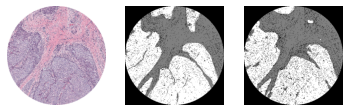

In [ ]:
visualize_predictions(resnet50, "resnet50")

1/1 [==============================] - 0s 307ms/step


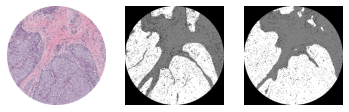

In [ ]:
visualize_predictions(vgg16, "vgg16")

1/1 [==============================] - 2s 2s/step


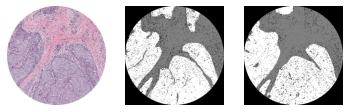

In [ ]:
visualize_predictions(densenet121, "densenet121")

1/1 [==============================] - 1s 1s/step


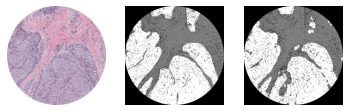

In [ ]:
visualize_predictions(inceptionv3, "inceptionv3")

1/1 [==============================] - 3s 3s/step


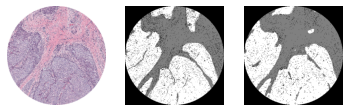

In [ ]:
visualize_predictions(inceptionresnetv2, "inceptionresnetv2")

1/1 [==============================] - 0s 277ms/step


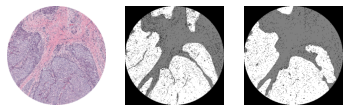

In [ ]:
visualize_predictions(unet, "unet", preprocess="no")

1/1 [==============================] - 0s 344ms/step


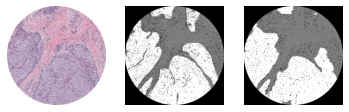

In [ ]:
visualize_predictions(linknet, "linknet", preprocess="no")

In [ ]:
visualize_predictions(pspnet, "pspnet", preprocess="no")

In [ ]:
visualize_predictions(fpn, "fpn", preprocess="no")